In [3]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#### 1. Problem Statement 

Understanding customer segmentation based on spending behavior and income levels can help businesses optimize marketing strategies and improve customer targeting. \
 We first apply Logistic Regression for supervised learning and then transition to K-Means clustering to uncover natural customer groups.


### 2. Data understanding

In [4]:
# load data set

df = pd.read_csv("Mall_Customers.csv")

In [5]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [7]:
df.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [8]:
df.shape

(200, 5)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [10]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [11]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [12]:
df["Genre"].unique()

array(['Male', 'Female'], dtype=object)

#### EDA

In [13]:
# convert categorical into int

df["Genre"] = df["Genre"].map({"Male" : 1 , "Female" : 0})

In [14]:
df["Genre"].unique()

array([1, 0])

Text(0.5, 1.0, 'Heat Plot of Mall Customer')

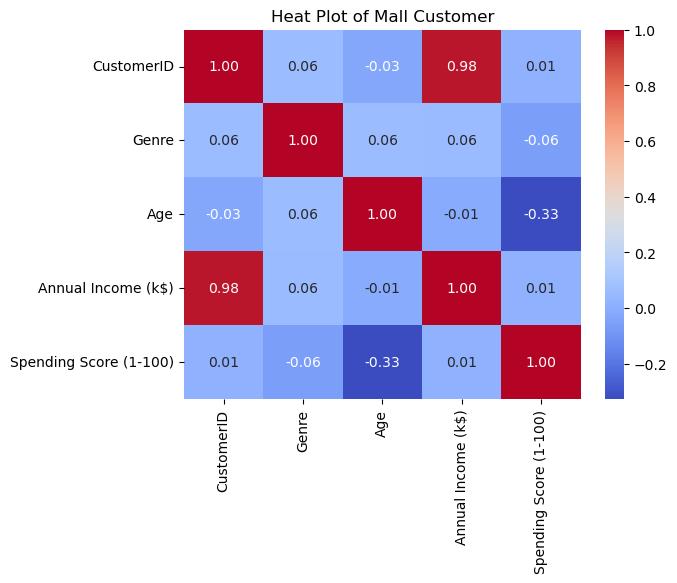

In [15]:
corr = df.select_dtypes(include=["number"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heat Plot of Mall Customer")



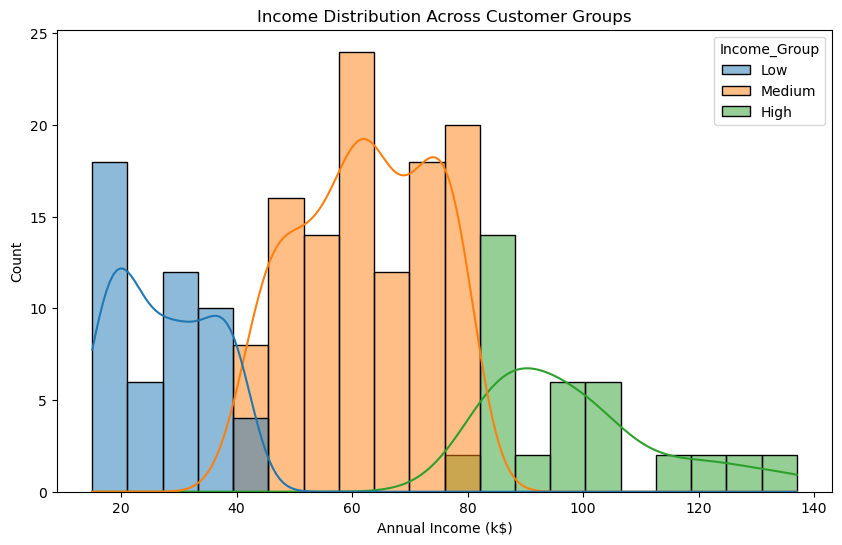

In [16]:
# Income Distribution Visualization
plt.figure(figsize=(10, 6))
df["Income_Group"] = pd.cut(df["Annual Income (k$)"], bins=[0, 40, 80, 150], labels=["Low", "Medium", "High"])
sns.histplot(data=df, x="Annual Income (k$)", hue="Income_Group", bins=20, kde=True)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Count")
plt.title("Income Distribution Across Customer Groups")
plt.show()




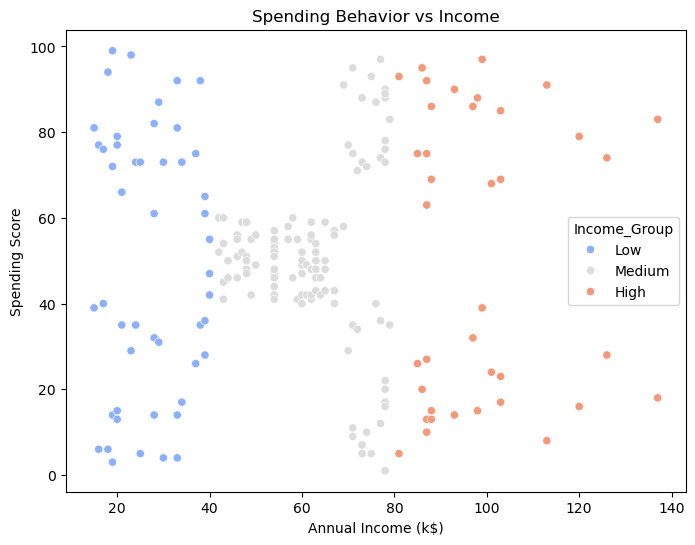

In [17]:
# Spending Score vs Income
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["Annual Income (k$)"], y=df["Spending Score (1-100)"], hue=df["Income_Group"], palette="coolwarm")
plt.title("Spending Behavior vs Income")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.show()


In [18]:
df["Income_Group"].unique()

['Low', 'Medium', 'High']
Categories (3, object): ['Low' < 'Medium' < 'High']

Text(0.5, 1.0, 'Distribution of Annual Income Across Age Groups')

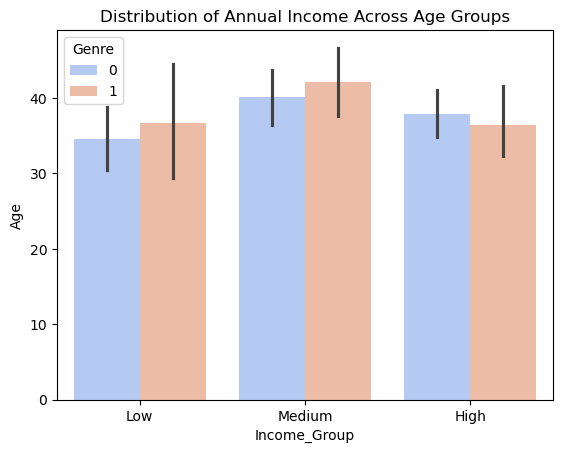

In [19]:

sns.barplot(data=df, x="Income_Group", y="Age",  hue = "Genre",palette="coolwarm")

# Add labels and title
plt.xlabel("Income_Group")
plt.ylabel("Age")
plt.title("Distribution of Annual Income Across Age Groups")


### 3. Model Building

### 1. Apply Supervised ML Technique

### Data preprocessing

#### 1. Remove Outliers

Text(0.5, 1.0, 'Boxplot to Identify Outliers')

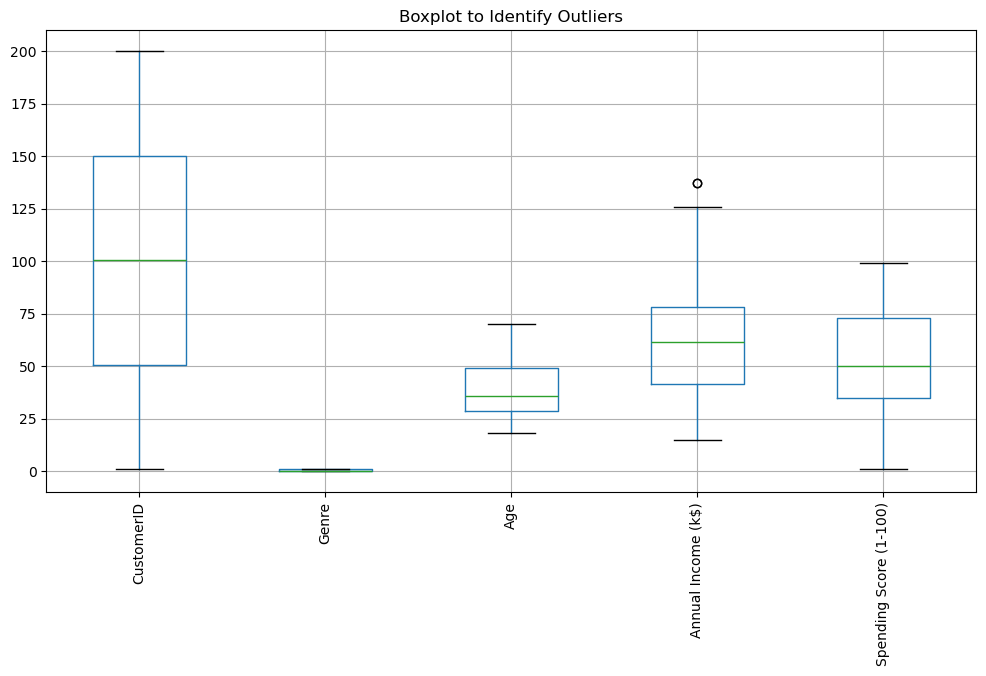

In [20]:

# Create boxplots for all numerical columns to check outliers
plt.figure(figsize=(12,6))
df.boxplot()
plt.xticks(rotation=90)  # Rotation of column name in x axis 
plt.title("Boxplot to Identify Outliers")


In [21]:
df["Income_Group"].unique()

['Low', 'Medium', 'High']
Categories (3, object): ['Low' < 'Medium' < 'High']

In [22]:

df["Income_Group"] = df["Income_Group"].astype(str).map({"Low": 1, "Medium": 2, "High": 3})
print(df["Income_Group"].unique())  


[1 2 3]


In [23]:
print(df["Income_Group"].unique())  

[1 2 3]


In [24]:
df.dtypes

CustomerID                int64
Genre                     int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
Income_Group              int64
dtype: object

In [25]:
# remove outlires and replace with lower/upper bound

q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 +1.5 * iqr
df_clean = df.copy()
for i in df_clean.columns:
    df_clean[i] = np.where(df_clean[i] < lower_bound[i] , lower_bound[i] , df_clean[i])
    df_clean[i] = np.where(df_clean[i] > upper_bound[i] , upper_bound[i] , df_clean[i])


Text(0.5, 1.0, 'Boxplot After Removing Outliers')

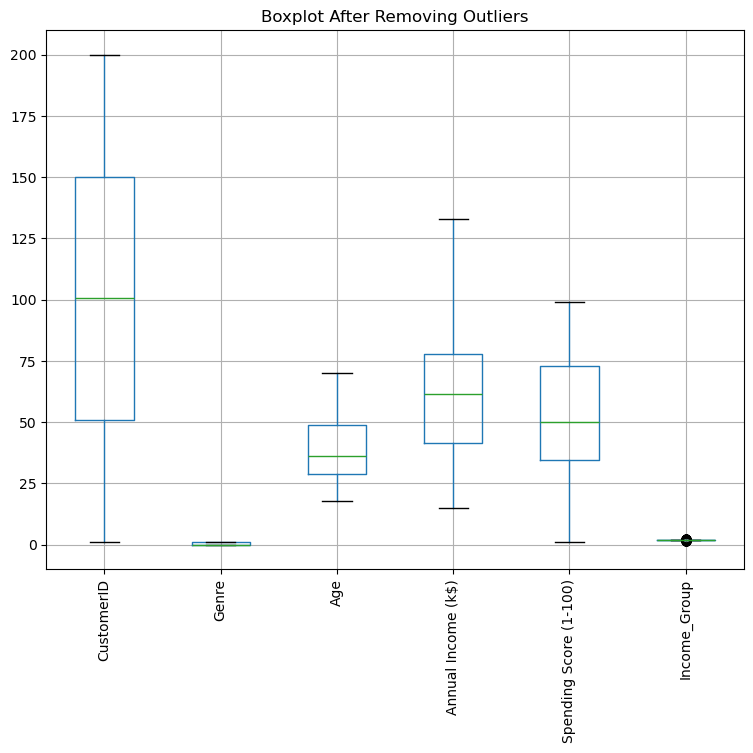

In [26]:
# check remove outlires

plt.figure(figsize=(9,7))
df_clean.boxplot()
plt.xticks(rotation = 90)
plt.title("Boxplot After Removing Outliers")

#### 2. Select Features and Labels

In [27]:
# Select features and labels
x = df_clean.drop(columns=["Income_Group", "CustomerID"])
y = df_clean["Income_Group"]


#### 3. Split Dataset for Training and Testing

In [28]:
x_train , x_test , y_train , y_test = train_test_split(x, y , test_size=0.2 , random_state=42)

#### 4. Normalization

In [29]:

scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

#### Training

In [30]:
model = LogisticRegression()

In [31]:
print(y_train.dtype)
print(y_train.unique())  # Ensure it contains 1, 2, or 3, not continuous values

float64
[2.    2.375 1.375]


In [32]:
y_train = y_train.round().astype(int)
y_test = y_test.round().astype(int)


In [33]:
df_clean["Income_Group"]

0      1.375
1      1.375
2      1.375
3      1.375
4      1.375
       ...  
195    2.375
196    2.375
197    2.375
198    2.375
199    2.375
Name: Income_Group, Length: 200, dtype: float64

In [34]:
model.fit(x_train , y_train)

LogisticRegression()

In [35]:
score_rate = model.score(x_train , y_train)
print("Training Accuracy : " ,score_rate)

Training Accuracy :  0.975


In [36]:
y_predict = model.predict(x_test)
y_predict

array([2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])

### 4. Evaluation

In [37]:
accuracy = accuracy_score(y_test , y_predict)

print("Accuracy Score:", accuracy)

Accuracy Score: 1.0


In [38]:
MAE = mean_absolute_error(y_test, y_predict)
print("Mean Absolute Error : " , MAE)


Mean Absolute Error :  0.0


### 2. Apply Unsupervised Learning

In [39]:
df_clean.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Income_Group'],
      dtype='object')

#### 1. Features

In [40]:

X = df_clean.select_dtypes(include=["number"])[["Annual Income (k$)", "Spending Score (1-100)"]]

#### 2. Normalization

In [41]:
# Standardize features
scale = StandardScaler()
X_scaled = scale.fit_transform(X)


#### 3. Elbow method the Decide number of Clusters

In [42]:



inertia = []
for i in range(1 , 10):
    model = KMeans(n_clusters=i , random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

d:\Env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can a

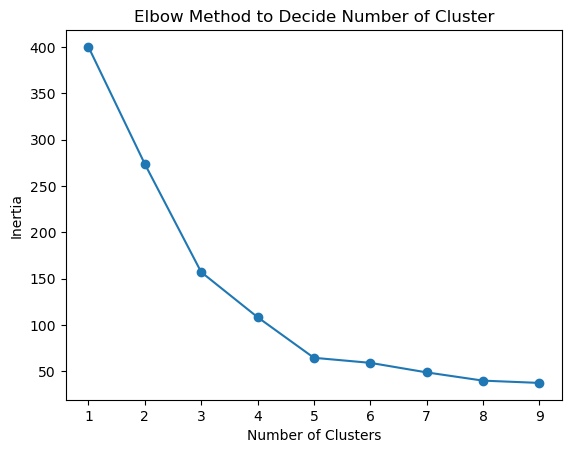

In [43]:
plt.plot(range (1, 10),inertia, marker = "o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Decide Number of Cluster")
plt.show()

In [44]:

# Apply K-Means clustering
model = KMeans(n_clusters=3, init="k-means++" , random_state=42)
df_clean["Cluster"] = model.fit_predict(X_scaled)


d:\Env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [45]:

df_clean["Cluster"] = model.labels_


In [46]:
df_clean.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Income_Group,Cluster
0,1.0,1.0,19.0,15.0,39.0,1.375,2
1,2.0,1.0,21.0,15.0,81.0,1.375,2
2,3.0,0.0,20.0,16.0,6.0,1.375,2
3,4.0,0.0,23.0,16.0,77.0,1.375,2
4,5.0,0.0,31.0,17.0,40.0,1.375,2


#### 4.Evaluation

In [47]:
sil_score = silhouette_score(X_scaled, model.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.4671147769403908


Explained Variance Ratio: [0.50496488 0.49503512]


Text(0, 0.5, 'Principle Component 2')

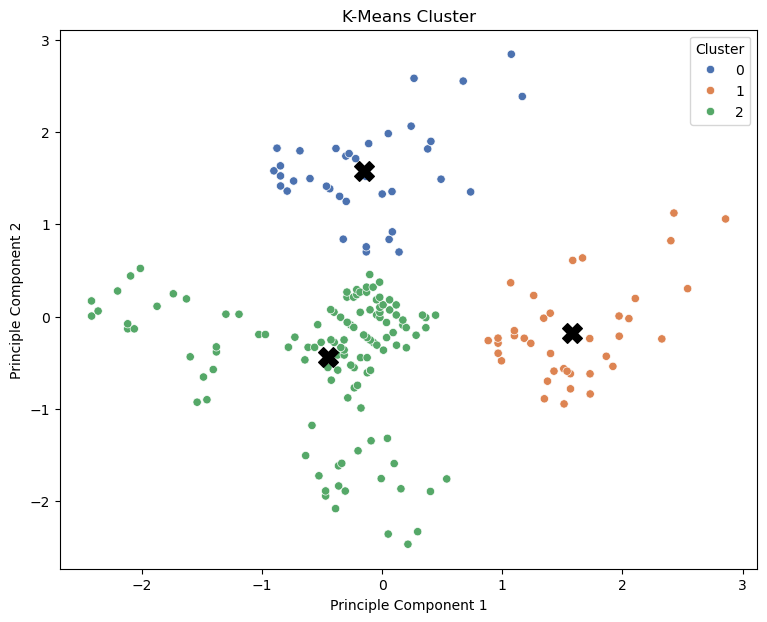

In [48]:
# Apply PCAto deduce feature to 2D

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_scaled)

 # Check explained variance ratio 
print("Explained Variance Ratio:", pca.explained_variance_ratio_) 

# # Add PCA component to the dataframe 
df_clean["PCA1"] = x_pca[: , 0]
df_clean["PCA2"] = x_pca[: , 1]
# visuallize the cluster
plt.figure(figsize=(9,7))
sns.scatterplot( data=df_clean ,x= "PCA1" , y= "PCA2" ,hue="Cluster" , palette="deep")
centers = pca.transform(model.cluster_centers_)
plt.scatter(centers[: , 0] , centers[: , 1 ] , c="black" , s=200 ,  marker="X")
plt.title("K-Means Cluster")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")


### Conclusion

In [49]:


# Extract customer segmentation insights
cluster_summary = df_clean.groupby("Cluster").agg({
    "Annual Income (k$)": ["mean", "median"],
    "Spending Score (1-100)": ["mean", "median"],
    "Age": ["mean", "median"]
})
print("Cluster Summary:\n", cluster_summary)



Cluster Summary:
         Annual Income (k$)        Spending Score (1-100)               Age  \
                      mean median                   mean median       mean   
Cluster                                                                      
0                86.888158   80.0              18.631579   16.5  40.394737   
1                86.429487   79.0              82.128205   83.0  32.692308   
2                44.154472   46.0              49.829268   50.0  40.325203   

                
        median  
Cluster         
0         41.5  
1         32.0  
2         38.0  


In [50]:
# Define cluster labels based on observed patterns
cluster_labels = {
    0: "Budget-Conscious Shoppers (Low Spending, Low Income)",
    1: "Value-Driven Spenders (Medium Income, High Spending)",
    2: "Luxury Buyers & Conservative Spenders (High Income, Varied Spending)"
}

df_clean["Segment"] = df_clean["Cluster"].map(cluster_labels)


C:\Users\Hp\AppData\Local\Temp\ipykernel_19024\311448623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clean, x="Segment", y="Annual Income (k$)", palette="coolwarm")


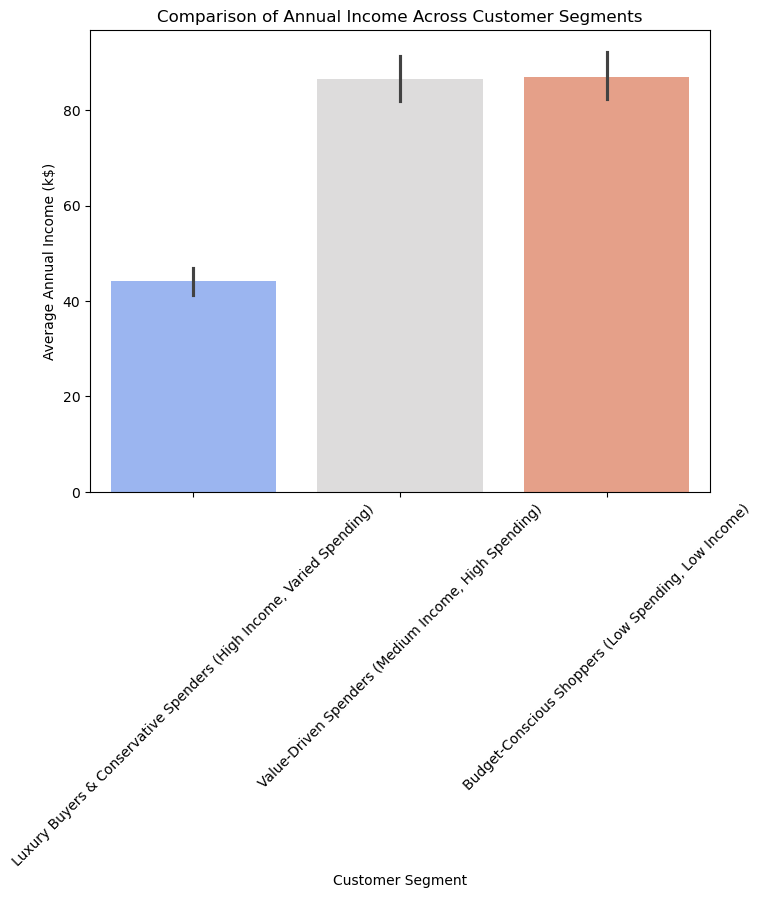

In [51]:

# Visualize the average annual income per segment
plt.figure(figsize=(8, 6))
sns.barplot(data=df_clean, x="Segment", y="Annual Income (k$)", palette="coolwarm")
plt.xlabel("Customer Segment")
plt.ylabel("Average Annual Income (k$)")
plt.title("Comparison of Annual Income Across Customer Segments")
plt.xticks(rotation=45)
plt.show()

